# Helper functions

In [39]:
from typing import List

def not_enough_plates(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[int]:
    wells_available = plate_size * well_num
    wells_needed = 0
    experiment_count = len(replicas)
    for experiment_number in range(experiment_count):
        wells_needed += len(samples[experiment_number]) * len(reagents[experiment_number]) * replicas[experiment_number]
    
    if wells_needed > wells_available:
        return [1, wells_needed, wells_available]
    else:
        return [0, wells_needed, wells_available]


# The filling algorithm should do a few things.

1. There are two possible sizes of microtiter plates 96-well (12x8) and 384-well (24x16) - return an error if there is overflow.
2. Keep experiments grouped as much as possible - within experiments group samples and reagents

# #1 Naive approach - greedily fill the plates and only group reagents and specimen that repeat within experiments.
The plates will be represented as 12x8 or 24x16 matrix depending on the input and the cells will be filled iteratively experiment by experiment.
The plate will be filled row by row from left to right and will be added to a result list once it is filled or all experiments are placed in the wells.

In [40]:
plate_size = 96
samples = [['Sam 1', 'Sam 2', 'Sam 3'], ['Sam 1', 'Sam 3', 'Sam 4']]
reagents = [['Reag X', 'Reag Y'], ['Reag Y', 'Reag Z']]
replicas = [1, 3]
well_num = 1

class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

def greedy_fill(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[List[str]]:
    not_enough, wells_needed, wells_available = not_enough_plates(plate_size, samples, reagents, replicas, well_num)
    if not_enough:
        error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
        raise PlateFillError(error_message)

    print(f"Log message: Enough wells are available to distribute experiments.")
    
    if plate_size == 96:
        num_rows = 8
        num_cols = 12
    elif plate_size == 384:
        num_rows = 16
        num_cols = 24

    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
    result = []

    current_well = 0
    experiment_count = len(replicas)

    for experiment_number in range(experiment_count):
        experiment_samples = samples[experiment_number]
        experiment_reagents = reagents[experiment_number]
        experiment_replicas = replicas[experiment_number]

        for replica in range(experiment_replicas):
            for reagent in experiment_reagents:
                for sample in experiment_samples:
                    if current_well > plate_size:
                        result.append(plate)
                        plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
                        current_well = 0

                    row_index = current_well // num_cols
                    col_index = current_well % num_cols

                    plate[row_index][col_index] = [sample, reagent]

                    current_well += 1

    if plate:
        result.append(plate)

    return result

try:
    plates = greedy_fill(plate_size=96, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


    


Log message: Enough wells are available to distribute experiments.


The naive approach didn't turn out amazing even in the most simple of cases. Therefore I will try to implement a different approach. I will not group the wells by experiment, but rather I will group them by reagents and sample combination counts and will plot them like this. This approach is only slightly more advanced, but should still be fairly naive to implement.

In [68]:
from typing import List
from collections import Counter, defaultdict

plate_size = 96
samples = [['Sam 1', 'Sam 2', 'Sam 3'], ['Sam 1', 'Sam 3', 'Sam 4']]
reagents = [['Reag X', 'Reag Y'], ['Reag Y', 'Reag Z']]
replicas = [1, 3]
well_num = 1

class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

def sort_by_reagents_and_fill(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[List[str]]:
    not_enough, wells_needed, wells_available = not_enough_plates(plate_size, samples, reagents, replicas, well_num)
    if not_enough:
        error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
        raise PlateFillError(error_message)

    print(f"Log message: Enough wells are available to distribute experiments.")
    
    if plate_size == 96:
        num_rows = 8
        num_cols = 12
    elif plate_size == 384:
        num_rows = 16
        num_cols = 24


    experiment_count = len(replicas)
    sample_per_reagent_counter = defaultdict(Counter)
    reagent_counter = Counter()

    for experiment_number in range(experiment_count):
        experiment_samples = samples[experiment_number]
        experiment_reagents = reagents[experiment_number]
        experiment_replicas = replicas[experiment_number]

        for reagent in experiment_reagents:
            for sample in experiment_samples:
                sample_per_reagent_counter[reagent][sample] += experiment_replicas
                reagent_counter[reagent] += experiment_replicas

    reagents_sorted_by_frequency = [key for key, _ in reagent_counter.most_common()]

    current_well = 0
    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
    result = []

    for reagent in reagents_sorted_by_frequency:
        sample_sorted_by_frequency = [(key, value)for key, value in sample_per_reagent_counter[reagent].most_common()]
        for sample, freq in sample_sorted_by_frequency:
            for i in range(freq):
                if current_well > plate_size:
                    result.append(plate)
                    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
                    current_well = 0

                row_index = current_well // num_cols
                col_index = current_well % num_cols

                plate[row_index][col_index] = [sample, reagent]

                current_well += 1
    
    if plate[0][0]:
        result.append(plate)

    return result

try:
    plates = sort_by_reagents_and_fill(plate_size=96, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
    print(plates)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


    


Log message: Enough wells are available to distribute experiments.
[[[['Sam 1', 'Reag Y'], ['Sam 1', 'Reag Y'], ['Sam 1', 'Reag Y'], ['Sam 1', 'Reag Y'], ['Sam 3', 'Reag Y'], ['Sam 3', 'Reag Y'], ['Sam 3', 'Reag Y'], ['Sam 3', 'Reag Y'], ['Sam 4', 'Reag Y'], ['Sam 4', 'Reag Y'], ['Sam 4', 'Reag Y'], ['Sam 2', 'Reag Y']], [['Sam 1', 'Reag Z'], ['Sam 1', 'Reag Z'], ['Sam 1', 'Reag Z'], ['Sam 3', 'Reag Z'], ['Sam 3', 'Reag Z'], ['Sam 3', 'Reag Z'], ['Sam 4', 'Reag Z'], ['Sam 4', 'Reag Z'], ['Sam 4', 'Reag Z'], ['Sam 1', 'Reag X'], ['Sam 2', 'Reag X'], ['Sam 3', 'Reag X']], [[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]], [[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]], [[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]], [[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]], [[None], [None], [None], [None]

# Visualize the resulting plates

Plate #1
Wells colored by reagents


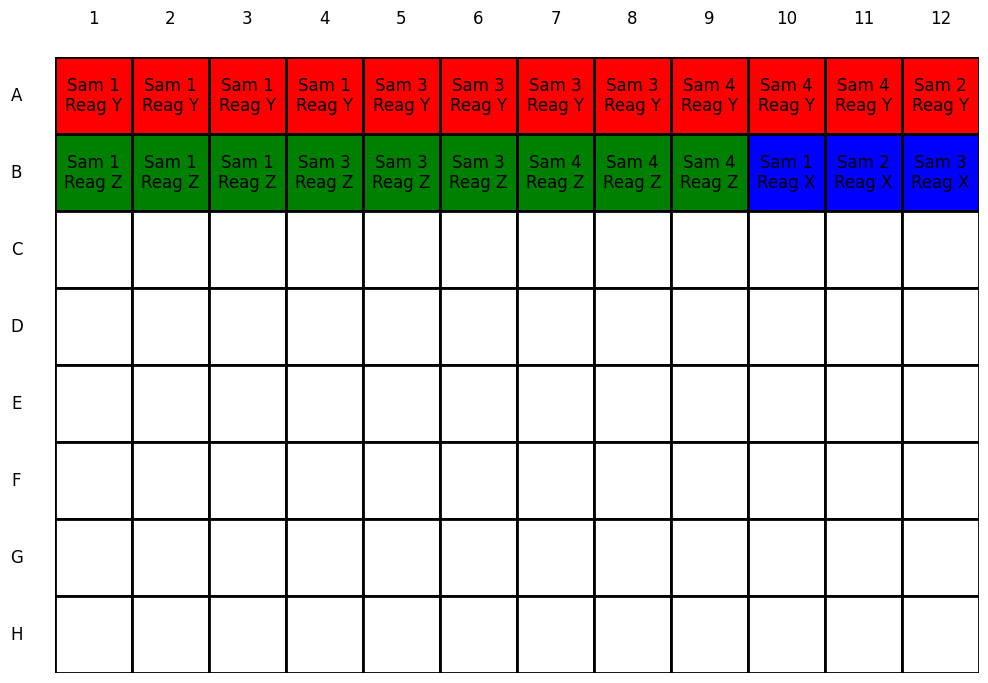

Wells colored by samples


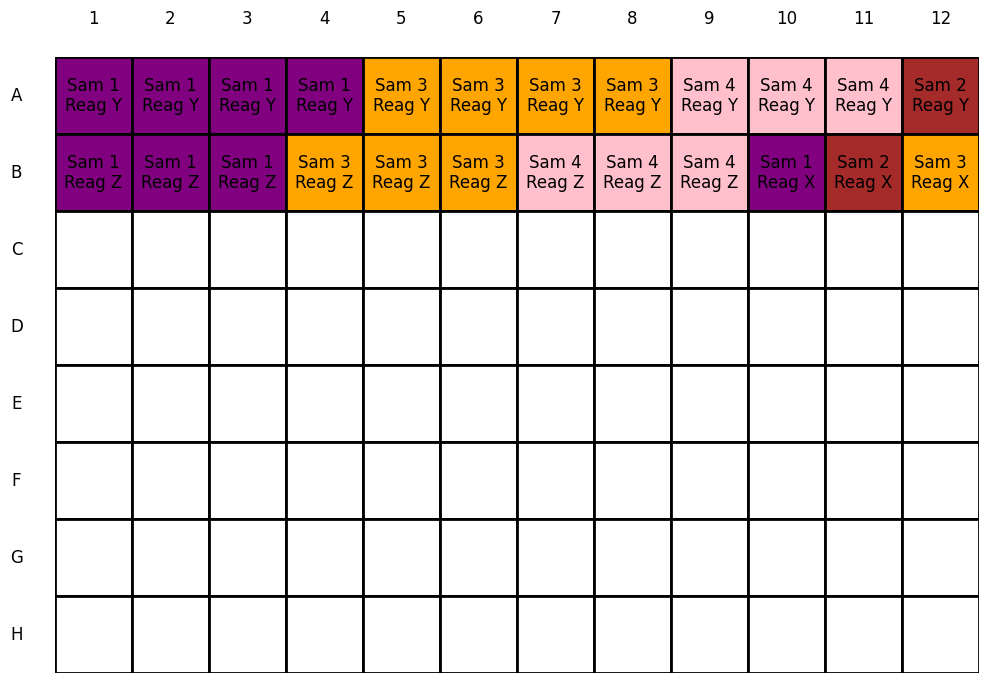

In [73]:
import matplotlib.pyplot as plt
import itertools

def plot_plate_color_reagent(plate, color_map):
    _, ax = plt.subplots(figsize=(12, 8))
    for i, row in enumerate(plate):
        for j, well in enumerate(row):
            if well and all(w is not None for w in well):
                reagent = well[1]
                if reagent not in color_map:
                    color_map[reagent] = next(color_cycle)
                ax.text(j, i, f"{well[0]}\n{well[1]}", ha='center', va='center', fontsize=12, color='black')
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color_map[reagent], edgecolor='black', linewidth=2))
            else:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2))

    if plate_size == 96:
        row_labels = [chr(i) for i in range(ord('A'), ord('A') + 8)]
        col_labels = [i for i in range(1, 13)]
    elif plate_size == 384:
        row_labels = [chr(i) for i in range(ord('A'), ord('A') + 16)]
        col_labels = [i for i in range(1, 25)]

    for i, label in enumerate(row_labels):
        ax.text(-1, i, label, ha='center', va='center', fontsize=12, color='black')

    for j, label in enumerate(col_labels):
        ax.text(j, -1, str(label), ha='center', va='center', fontsize=12, color='black')

    ax.set_xlim(-0.5, len(plate[0])-0.5)
    ax.set_ylim(-0.5, len(plate)-0.5)
    ax.set_aspect('equal', 'box')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

def plot_plate_color_samples(plate, color_map):
    _, ax = plt.subplots(figsize=(12, 8))
    for i, row in enumerate(plate):
        for j, well in enumerate(row):
            if well and all(w is not None for w in well):
                sample = well[0]
                if sample not in color_map:
                    color_map[sample] = next(color_cycle)
                ax.text(j, i, f"{well[0]}\n{well[1]}", ha='center', va='center', fontsize=12, color='black')
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color_map[sample], edgecolor='black', linewidth=2))
            else:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2))

    if plate_size == 96:
        row_labels = [chr(i) for i in range(ord('A'), ord('A') + 8)]
        col_labels = [i for i in range(1, 13)]
    elif plate_size == 384:
        row_labels = [chr(i) for i in range(ord('A'), ord('A') + 16)]
        col_labels = [i for i in range(1, 25)]

    for i, label in enumerate(row_labels):
        ax.text(-1, i, label, ha='center', va='center', fontsize=12, color='black')

    for j, label in enumerate(col_labels):
        ax.text(j, -1, str(label), ha='center', va='center', fontsize=12, color='black')

    ax.set_xlim(-0.5, len(plate[0])-0.5)
    ax.set_ylim(-0.5, len(plate)-0.5)
    ax.set_aspect('equal', 'box')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}

for i, plate in enumerate(plates, 1):
    print(f"Plate #{i}")
    print(f'Wells colored by reagents')
    plot_plate_color_reagent(plate, color_map)
    print(f'Wells colored by samples')
    plot_plate_color_samples(plate, color_map)
    # plt.savefig(f'Plate_{i}.png')



